# Learning Goals
By the end of this tutorial, you will:
* Understand how to query data on a target from the MAST archive.
* Be able to plot a timeline of all observations of the target.
* Learn to plot a spectrum from any historical observation. 
* Make your own comparisons and conclusions based on the target. 

# Introduction

Quasars are extremely luminous astronomical objects that can be found at the center of some galaxies. They are powered by gas spiraling at high velocity into a super-massive black hole. The brightest quasars are capable of outshining all the stars in their galaxy, they can be seen from billions of light-years away. The first quasar ever discovered is called **3c273**, it is one of the most luminous quasars and therefore one of the most luminous objects in the observable universe. It is at a distance of 749 Megaparsecs [1 Megaparsec = 1 million parsecs = 3.26 million lightyears] with an absolute magnitude of −26.7, meaning that if it were at a distance of 10 parsecs, it would be as bright in our sky as the Sun. <br>
    
Quasar **3c273** is the target we will focus on in this tutorial. We will first gather all the observations of this quasar from the MAST archive. Then, we will plot those observations as a function of wavelength versus time. Finally, we will plot a spectrum from one of the observations. These two plots should help us to understand what the history of this quasar looks and then we can try to draw our own conclusions.

# Imports
The following cell holds the imported packages. These packages are necessary for running the rest of the cells in this notebook. A description of each import is as follows:

* *numpy* to handle array functions
* *pandas* to handle date conversions
* *fits from astropy.io* for accessing FITS files
* *Table from astropy.table* for creating tidy tables of the data
* *matplotlib.pyplot* for plotting data
* *Mast and Observations from astroquery.mast* for querying data and observations from the MAST archive


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import itertools
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from astroquery.mast import Mast
from astroquery.mast import Observations
from astroquery.mast import Catalogs

# Main Content

## Gather the Data

We are going to use the **astroquery.mast Observations** package to gather our data from the MAST Archive. There are a number of ways to go about querying data with this package. For our purposes, we will be using the **Observations.query_object()** function which takes in the name of the target and optionally, a radius around the target (the default is 0.2 degrees if not provided). You can find a link to the MAST data column descriptions in the **"Additional Resources"** section below. 


In [2]:
#define target name
target_name = "3c273"

#We'll name the data "obs_table" for "observations table"
obs_table = Observations.query_object(target_name)

#lets print out the first 10 entries
obs_table[:10] 

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,distance
str7,str11,str12,str13,str9,str30,str16,str29,str43,str53,float64,float64,str10,str21,int64,float64,float64,float64,float64,float64,str112,float64,str31,str15,int64,str23313,str183,str184,str16,bool,float64,str8,float64
science,WUPPE,--,ASTRO-2 WUPPE,--,--,UV,3C273,--,3c273_842410_2,187.279228699,2.0536465492,spectrum,--,1,49788.75555556,49788.77111111,1344.0,155400000000.0,314400000000.00006,--,nan,--,--,--,CIRCLE ICRS 187.279228699 2.0536465492 0.00166666666667,http://archive.stsci.edu/pub/browse/previews/astro/wuppe/gif/3c273_842410_2_hwa.gif,http://archive.stsci.edu/pub/vospectra/wuppe2/3c273_842410_2_hw_vo.fits,PUBLIC,--,5885.0,389158,0.5380910908285884
science,WUPPE,--,ASTRO-2 WUPPE,--,--,UV,3C273,--,3c273_842420_2,187.279228699,2.0536465492,spectrum,--,1,49791.80069444,49791.80958333,768.0,153400000000.0,314400000000.00006,--,nan,--,--,--,CIRCLE ICRS 187.279228699 2.0536465492 0.00166666666667,http://archive.stsci.edu/pub/browse/previews/astro/wuppe/gif/3c273_842420_2_hwa.gif,http://archive.stsci.edu/pub/vospectra/wuppe2/3c273_842420_2_hw_vo.fits,PUBLIC,--,5885.0,389159,0.5380910908285884
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0046-4-1,187.87668552440834,3.9280397807776652,image,"Ricker, George",3,59551.059444895836,59578.20097240741,475.199787,600.0,1000.0,--,59603.0,N/A,--,46,POLYGON 184.932525 11.53865 195.739653 7.251302 190.881035 -3.966972 179.962764 0.80245 184.932525 11.53865,--,--,PUBLIC,False,nan,71644386,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,377297839,--,tess2021336043614-s0046-0000000377297839-0217-a_fast,187.277915345024,2.05238856846283,timeseries,"Ricker, George",3,59551.06217576389,59578.201395069445,20.0,600.0,1000.0,--,59603.0,G04048,--,46,CIRCLE 187.27791535 2.05238857 0.00138889,--,mast:TESS/product/tess2021336043614-s0046-0000000377297839-0217-a_fast-lc.fits,PUBLIC,False,nan,71498620,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,377297839,--,tess2021336043614-s0046-0000000377297839-0217-s,187.277915345024,2.05238856846283,timeseries,"Ricker, George",3,59551.06217576389,59578.20093207176,120.0,600.0,1000.0,--,59603.0,G04048,--,46,CIRCLE 187.27791535 2.05238857 0.00138889,--,mast:TESS/product/tess2021336043614-s0046-0000000377297839-0217-s_lc.fits,PUBLIC,False,nan,71498623,0.0
science,SWIFT,--,UVOT,--,U,OPTICAL,3C273,--,00031659002,187.24869534790196,2.09268126402627,cube,--,2,55269.6744444,55269.6763889,145.73962166116092,301400000000.0,394200000000.0,--,nan,--,--,--,POLYGON -172.64860799999997 2.045127 -172.673162 2.123497 -172.755491 2.100351 -172.754953783567 2.0986306519656761 -172.75576999999998 2.098398 -172.731491 2.020867 -172.65056200000004 2.044012 -172.65072103180597 2.0445258640491044 -172.64860799999997 2.045127 -172.64860799999997 2.045127,http://archive.stsci.edu/cgi-bin/hla/fitscut.cgi?red=sw00031659002uuu[2]&size=ALL&output_size=384,http://archive.stsci.edu/missions/swift_uvot/00031659/00031659002/sw00031659002uuu_sk.img,PUBLIC,--,5885.0,1429298,0.0
science,SWIFT,--,UVOT,--,V,OPTICAL,3C273,--,00031659002,187.24869534790196,2.09268126402627,cube,--,2,55269.6658681,55269.6682292,178.9706722651868,493000000000.0,599600000000.0,--,nan,--,--,--,POLYGON -172.64792599999998 2.043778 -172.67220099999997 2.122147 -172.754529 2.099002 -172.75429086847251 2.0982393920211888 -172.75521200000003 2.09798 -172.730933 2.02017 -172.7299984153064 2.0204396028160638 -172.72997199999998 2.020355 -172.64792599999998 2.043778 -172.64792599999998 2.043778,http://archive.stsci.edu/cgi-bin/hla/fitscut.cgi?red=sw00031659002uvv[2]&size=ALL&output_size=384,http://archive.stsci.edu/missions/swift_uvot/00031659/00031659002/s

### Compile necessary variables for plotting
Before we start parsing our observations table, lets recall what we want to do with it. <br> 
<br>
First, we want to plot an Historical Observational Coverage Plot, where the x-axis will be time and the y-axis will be wavelength. We are also going to want to label or color each observation according to what mission it corresponds to. So, we are going need a variable for:
* array of times of all observations
* array of wavelengths of all observations
* array of mission names of all observations. <br> 

Some modifications to the quieried data will be desired for easy visualization. 1) We will want to convert the Modified Julian Date returned from our MAST query to a Calendar Date so when we plot the timeline, it will be easy to tell when each observation was made. 2) MAST only holds columns for the minimum and maximum wavelength of the observation, for the Historic Observational Coverage plot, we only want one wavelength per time so we will calculate the median between each min and max wavelength value. <br>
<br>

In [3]:
#Parse the observations table to get the Time data
obs_times = obs_table["t_min"]

#Convert MJD to Calendar Date:
#initialize list for times as calendar dates
times = []
#loop through times quieried from MAST
for t in obs_times:
    #convert MJD to Julian date
    t = t + 2400000.5
    #convert Julian date to Calendar date 
    time = pd.to_datetime(t, unit = 'D', origin = 'julian')
    #add converted date to times list
    times.append(time.to_numpy())
#change list to numpy array for easy plotting
times = np.array(times)

#Parse observations table to get the wavelength data
wavelength_min = obs_table["em_min"]
wavelength_max = obs_table["em_max"]
#Due to an issue in the MAST database, we have to correct the some wavelength values that are off by a factor of 1e9
waves = []
for wave in wavelength_min:
    if wave/1e9 >= 1:
        waves.append(wave/1e9)
    else:
        waves.append(wave)
#change list to numpy array
waves = np.array(waves)

#Parse the observations table to get the mission names data
mission = obs_table["obs_collection"]
mission = np.array(mission)

## Historical Observational Coverage Plot 

We want to visualize the history of observations of 3c273 according to the wavelength of the observation. This plot will tell us much more if we change the color of each point to indicate which mission made the observation. 

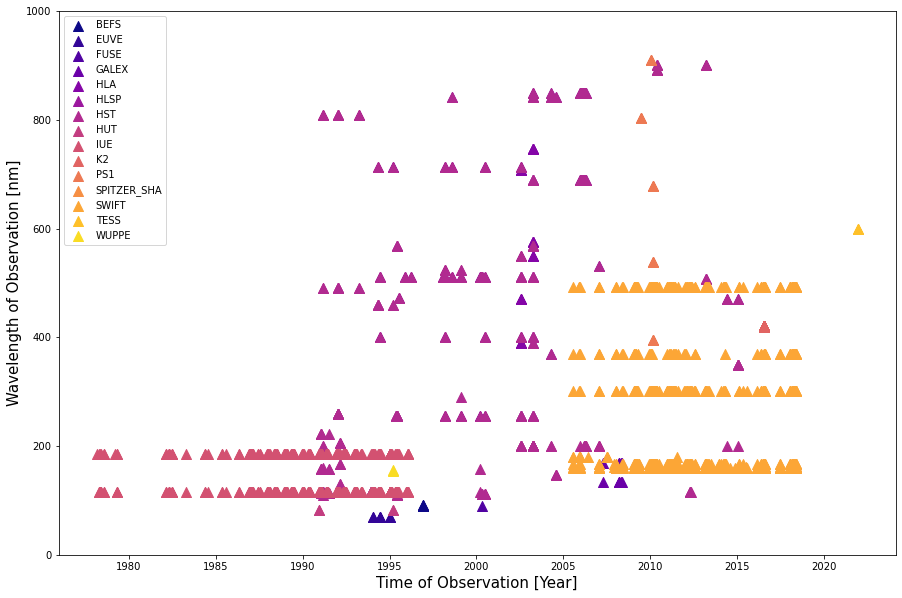

In [4]:
#make plot axes
fig = plt.figure()
fig.set_size_inches(15,10)
ax = fig.add_subplot()
        
#get color for every unique mission name
cm = plt.cm.get_cmap("plasma") 
num_colors = len(np.unique(mission))
ax.set_prop_cycle(color = [cm(1.*i/num_colors) for i in range(num_colors)])

#loop through the mission names
for i in np.unique(mission):
    #filter times and wavelengths by mission name
    ind = np.where(mission == i)
    #plot it
    ax.scatter(times[ind], waves[ind], label = i, s = 100, marker = "^")#, edgecolor = ecolor)

# plt.plot(times, wavelengths)

#place the legend
plt.legend()  
#set the limits of the y-axis
plt.ylim(10**-9,10**3)
# set the label of the x and y axes
plt.xlabel("Time of Observation [Year]", fontsize = 15)
plt.ylabel("Wavelength of Observation [nm]", fontsize = 15)
#show the plot
plt.show()


## Plot A Spectrum

Now, we want to plot a spectrum from one of our observations, where the x-axis will be wavelength and the y-axis will be flux (or what you can call brightness). For this plot we will need a variable for:

* array of wavelengths from one observation
* array of fluxes from one observation. 
<br>

We can use our Historical Observational Coverage plot to choose which observation to plot. Let's go with one from the Hubble Space Telescope (HST).

### First, query all Hubble Space Telescope spectra for 3c273

In [5]:
#Lets query all the observations of 3c273 from the Hubble Space Telescope
hst_table = Observations.query_criteria(objectname="3c273",radius="10 arcsec", dataproduct_type="spectrum", obs_collection="HST")

#Let's print out some relevant columns of this table
hst_table["instrument_name","filters","target_name","obs_id","calib_level","t_exptime"]


instrument_name,filters,target_name,obs_id,calib_level,t_exptime
str13,str9,str10,str9,int64,float64
FOS/BL,MIRROR,TALED,y0g40104t,1,53.76
FOS/BL,MIRROR,PG1226+023,y0g40105t,1,120.32
FOS/RD,G270H,WAVE,y0g4020kt,2,2.0
FOS/RD,G190H,WAVE,y0g40208t,2,8.0
FOS/RD,MIRROR,PG1226+023,y0g40203t,1,21.6
FOS/BL,MIRROR,PG1226+023,y0g40103t,1,43.2
FOS/RD,MIRROR,PG1226+023,y0g40205t,1,120.32
FOS/BL,MIRROR,PG1226+023,y0g40102t,1,0.24
FOS/RD,MIRROR,PG1226+023,y0g40201t,1,1.2


### Next, get a summary of the various instrument and filter combinations available

In [6]:
#All telescopes will have multiple instruments and observing modes, here we'll print a summary of HST's
hst_table['count'] = 1
columns = hst_table.group_by(["instrument_name","filters"])
summary_table = columns["instrument_name","filters","count"].groups.aggregate(np.sum)
summary_table["exptime"] = columns['t_exptime'].groups.aggregate(np.mean)
summary_table["expmax"] = columns['t_exptime'].groups.aggregate(np.max)
summary_table["exptime"].format = ".1f"
summary_table["expmax"].format = ".1f"

#Take a look at the summary table
summary_table

instrument_name,filters,count,exptime,expmax
str13,str9,int64,float64,float64
COS/FUV,G130M,8,564.4,1192.2
FOS/BL,G130H,13,822.8,2000.0
FOS/BL,G190H,2,1440.0,1440.0
FOS/BL,G270H,1,1440.0,1440.0
FOS/BL,MIRROR,6,36.7,120.3
FOS/RD,G190H,10,547.6,1410.0
FOS/RD,G270H,11,494.1,1410.0
FOS/RD,MIRROR,5,39.5,120.3
HRS,MIRROR-N2,7,nan,nan


### Now, we have to select observations for a specific instrument and filter combination

The COS G130M data looks like a good possibility. Let's look at the observations for that mode.

In [7]:
g130m_table = hst_table['obsid','obs_id','target_name','calib_level',
                        't_exptime','filters','em_min','em_max'][hst_table['filters']=='G130M']

#Print out the table of data for this specific filter configeration
g130m_table

obsid,obs_id,target_name,calib_level,t_exptime,filters,em_min,em_max
str8,str9,str10,int64,float64,str9,float64,float64
24140740,lbgl31rfq,3C273,1,398.0,G130M,115.0,145.0
24140742,lbgl31rhq,3C273,1,2.0,G130M,115.0,145.0
24140741,lbgl31rgq,3C273,1,113.0,G130M,115.0,145.0
24842818,lbgl31010,3C273,3,555.008,G130M,115.0,145.0
24842821,lbgl31040,3C273,3,555.04,G130M,115.0,145.0
24842822,lbgl31050,3C273,3,590.016,G130M,115.0,145.0
24842819,lbgl31020,3C273,3,1192.192,G130M,115.0,145.0
24842820,lbgl31030,3C273,3,1110.016,G130M,115.0,145.0


In [8]:
#We'll take the longest exposure in this filter and plot the spectrum
sel_table = g130m_table[np.argmax(g130m_table['t_exptime'])]

#Take a look at the selected observation's data table
sel_table

obsid,obs_id,target_name,calib_level,t_exptime,filters,em_min,em_max
str8,str9,str10,int64,float64,str9,float64,float64
24842819,lbgl31020,3C273,3,1192.192,G130M,115.0,145.0


### Get the Minimum Recommended Products for this observation

In [9]:
#query the observations from MAST to get a list of products for our selected observation
data_products = Observations.get_product_list(sel_table)
#Get the minimum required products
wprod = np.where((data_products['productGroupDescription']=='Minimum Recommended Products') & 
                 (data_products['productType']=='SCIENCE'))[0]

#Let's take a look at the products available for our selected observation
data_products[wprod]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str3,str8,str9,str62,str1,str44,str9,str28,str12,str1,str6,str5,str5,str27,int64,str8,str6,int64
24842819,HST,spectrum,lbgl31020,DADS XSM file - Calibrated combined extracted 1D spectrum COS,D,mast:HST/product/lbgl31020_x1dsum.fits,SCIENCE,Minimum Recommended Products,X1DSUM,--,CALCOS,3.4.0,12038,lbgl31020_x1dsum.fits,1814400,24842819,PUBLIC,3


### Download the data to plot

In [10]:
#Download the data for our selected observation
data = Observations.download_products(data_products[wprod], productType="SCIENCE")

#Print out confirmation that we downloaded a FITS file
data

INFO: Found cached file ./mastDownload/HST/lbgl31020/lbgl31020_x1dsum.fits with expected size 1814400. [astroquery.query]


Local Path,Status,Message,URL
str50,str8,object,object
./mastDownload/HST/lbgl31020/lbgl31020_x1dsum.fits,COMPLETE,None,None


In [11]:
#Take a peak at the FITS file we downloaded
filename = data['Local Path'][0]
fits.info(filename)

#Read the table with the spectrum from the FITS file
tab = Table.read(filename)
tab

Filename: ./mastDownload/HST/lbgl31020/lbgl31020_x1dsum.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     180   ()      
  1  SCI           1 BinTableHDU    318   2R x 16C   [4A, 1D, 1J, 16384D, 16384E, 16384E, 16384E, 16384E, 16384E, 16384E, 16384E, 16384E, 16384E, 16384E, 16384I, 16384E]   


SEGMENT,EXPTIME,NELEM,WAVELENGTH [16384],FLUX [16384],ERROR [16384],ERROR_LOWER [16384],GROSS [16384],GCOUNTS [16384],VARIANCE_FLAT [16384],VARIANCE_COUNTS [16384],VARIANCE_BKG [16384],NET [16384],BACKGROUND [16384],DQ [16384],DQ_WGT [16384]
,s,,Angstrom,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),ct / s,ct / s,ct,ct,ct,ct,ct / s,ct / s,,
bytes4,float64,int32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32
FUVA,1192.192,16384,1287.7223277258975 .. 1451.0011741699564,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,128 .. 128,0.0 .. 0.0
FUVB,1192.192,16384,1134.4437699392558 .. 1297.694753780682,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,128 .. 128,0.0 .. 0.0


### Plot the spectrum

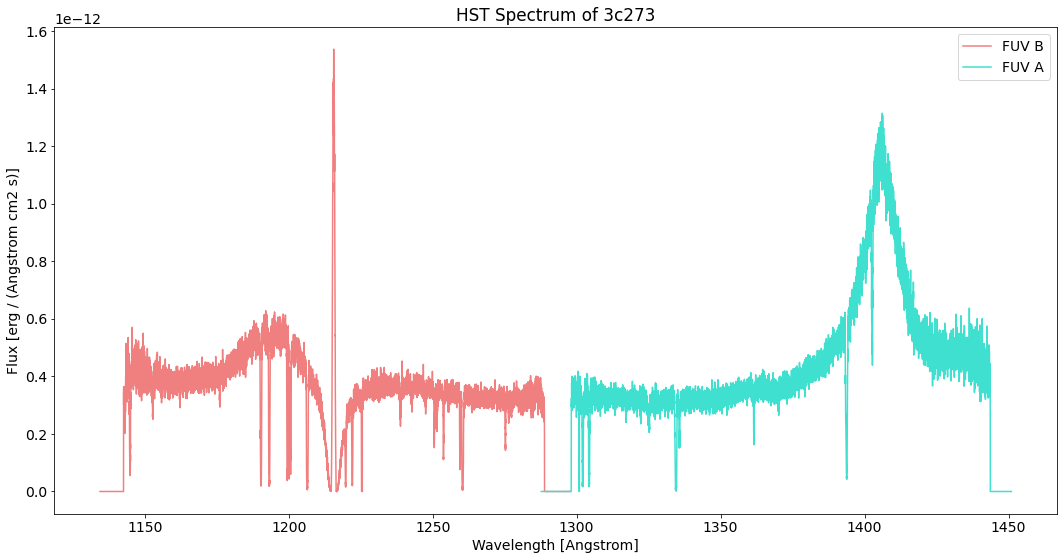

In [12]:
#Make the figure and set the font size globally
plt.rcParams.update({"font.size": 14})
plt.figure(1,(15,8))

#Gather the arrays from our data table
waves = tab['WAVELENGTH']
fluxes = tab["FLUX"]
segment = tab['SEGMENT']

#You'll notice from our data table that there are two segments to this observation, FUV A and FUV B
#Let's parse the spectra by their segment and plot them separately
ind_A = np.squeeze(np.where(fluxes != 0) and np.where(segment == 'FUVA'))
waves_A = waves[ind_A]
fluxes_A = fluxes[ind_A]
ind_B = np.squeeze(np.where(fluxes != 0) and np.where(segment == 'FUVB'))
waves_B = waves[ind_B]
fluxes_B = fluxes[ind_B]

#Plot both segments
plt.plot(waves_B, fluxes_B, label = "FUV B", color = 'lightcoral')
plt.plot(waves_A, fluxes_A, label = "FUV A", color = 'turquoise')

#Set the x and y axes labels and the title
plt.xlabel('Wavelength [{}]'.format(tab['WAVELENGTH'].unit))
plt.ylabel('Flux [{}]'.format(tab['FLUX'].unit))
plt.title("HST Spectrum of 3c273")

#plot the legend
plt.legend()

#give the figure a tight layout (optional)
plt.tight_layout()

# Exercises
### 1. Recognizing Familiar Emission Lines
Look at the spectrum we plotted, does anything stand out to you? 

In astronomy, spectral features at specific wavelengths are indicative of very well known elements. For example, an emission line at 1216 Angstroms is called Lyman Alpha. It is produced when an orbital electron of a hydrogen atom drops from the first excited state down to the ground state, emitting a photon. 

Does **3c273** have a Lyman Alpha emission line? Plot a vertical line at 1216 Angstroms to find out. 

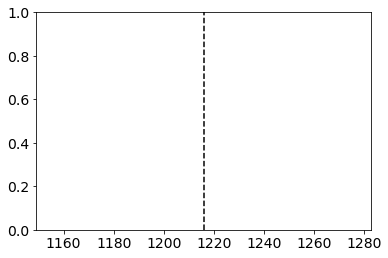

In [13]:
#Answer to exercise 1. 
#To plot a vertical line at any x-position, add the following line to the spectrum plotting cell

xval = 1216 #Lyman Alpha in Angstroms
plt.axvline(xval, color = "black", linestyle = "--")

# Additional Resources

You can find the name of each data column in our queried table here: https://mast.stsci.edu/api/v0/_c_a_o_mfields.html 

The SIMBAD profile on 3c273 can be found here: http://simbad.u-strasbg.fr/simbad/sim-id?Ident=3C+273 

Check out this youtube video by David Butler giving a 1 minute summary of **3c273**: https://youtu.be/VfBOIcKU8xU

Here is a neat article written about **3c723** by Phil Plait for SYFY: https://www.syfy.com/syfy-wire/most-distant-astronomical-object-ever-seen-in-1962 

# About this Notebook

**Author**: Emma Lieb <br>
**Last updated:** 08 July 2022

# Citations

* [Citation for `astropy`](https://www.astropy.org/acknowledging.html)
